In [4]:
import os

In [2]:
# Adding the part of code mentioned in the pdf below

#Uses pillow (you can also use another imaging library if you want)
from PIL import Image, ImageOps, ImageFont, ImageDraw

#Load the font and set the font size to 42
font = ImageFont.truetype('habbakuk/Habbakuk.ttf', 42)

#Character mapping for each of the 27 tokens
char_map = {'Alef' : ')',
            'Ayin' : '(',
            'Bet' : 'b',
            'Dalet' : 'd',
            'Gimel' : 'g',
            'He' : 'x',
            'Het' : 'h',
            'Kaf' : 'k',
            'Kaf-final' : '\\',
            'Lamed' : 'l',
            'Mem' : '{',
            'Mem-medial' : 'm',
            'Nun-final' : '}',
            'Nun-medial' : 'n',
            'Pe' : 'p',
            'Pe-final' : 'v',
            'Qof' : 'q',
            'Resh' : 'r',
            'Samekh' : 's',
            'Shin' : '$',
            'Taw' : 't',
            'Tet' : '+',
            'Tsadi-final' : 'j',
            'Tsadi-medial' : 'c',
            'Waw' : 'w',
            'Yod' : 'y',
            'Zayin' : 'z'}

#Returns a grayscale image based on specified label of img_size
def create_image(label, img_size):
    if (label not in char_map):
        raise KeyError('Unknown label!')

    #Create blank image and create a draw interface
    img = Image.new('L', img_size, 255)
    draw = ImageDraw.Draw(img)

    #Get size of the font and draw the token in the center of the blank image
    left, top, right, bottom = font.getbbox(char_map[label])
    w = right - left
    h = bottom - top
    draw.text(((img_size[0]-w)/2, (img_size[1]-h)/2), char_map[label], 0, font)

    return img

#Create a 50x50 image of the Alef token and save it to disk
#To get the raw data cast it to a numpy array
img = create_image('Alef', (50, 50))
img.save('example_alef.png')

In [9]:
clip = create_image('Ayin', (27,75))
os.makedirs('fonts/ayin', exist_ok=True)
clip.save('fonts/ayin/1.png')
img = create_image('Alef', (33, 100))
os.makedirs('fonts/alef', exist_ok=True)
img.save('fonts/alef/1.png')

<h1>Preprocess and segment</h1>

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
import PIL.ImageOps
import math



example_text_image_pillow = Image.open("image-data\P564-Fg003-R-C01-R01-binarized.jpg")
#example_text_image_cv = cv2.imread("sample-test-2025/124-Fg004.pbm")
#height, width, channels = example_text_image_cv.shape

def horizontal_projection(image, skew_range = 15): #skew alignment 
    skews = range(-skew_range,skew_range)
    sum_peaks = 0
    skew_val = 0
    peaks_locs = None
    num_peaks = math.inf
    for skew in skews:
        temp_rotated_image  = image.rotate(skew,fillcolor = 'white')
        projection = np.sum(temp_rotated_image, axis=1)
        smoothed_projection = gaussian_filter1d(projection, sigma=6)
        inverted_projection = np.max(smoothed_projection) - smoothed_projection
        peaks, _  = find_peaks(inverted_projection, prominence=200) 
        current_num_peaks = len(peaks)
        heights = smoothed_projection[peaks]
        current_sum_peaks = sum(heights)
        if  current_num_peaks < num_peaks:
            #if current_sum_peaks > sum_peaks:
            sum_peaks = current_sum_peaks
            skew_val = skew
            peaks_locs = peaks
        plt.figure(figsize=(10, 4))
        plt.plot(inverted_projection)
        plt.scatter(peaks, [inverted_projection[peak] for peak in peaks], color='red', label='peak')
        plt.title("Vertical Projection Profile")
        plt.xlabel("Row Index")
        plt.ylabel("Sum of Pixel Values")
        plt.grid(True)
        plt.show()
    return skew_val, peaks_locs

skew_val, peak_locs = horizontal_projection(example_text_image_pillow, 5)


In [72]:
skew_val

-3

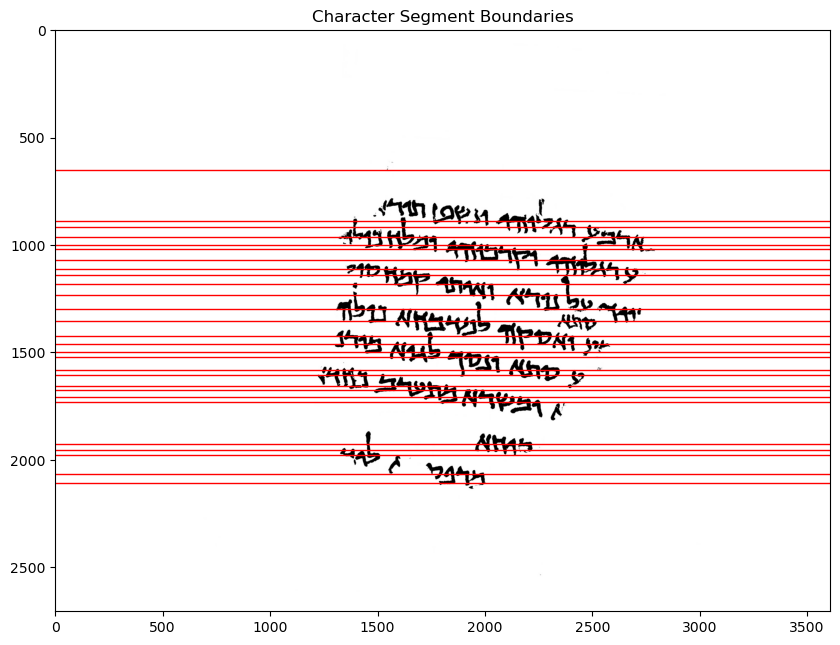

In [73]:
#plot
# Show original image with horizontal lines at character segment boundaries
plt.figure(figsize=(10, 8))
example_text_image_pillow = example_text_image_pillow.rotate(skew_val, fillcolor= "white")
plt.imshow(example_text_image_pillow, cmap='gray')
for peak in peak_locs:
    plt.axhline(peak, color='red', linestyle='-', linewidth=1)
plt.title("Character Segment Boundaries")
plt.show()

In [39]:
plt.figure(figsize=(10, 4))
plt.plot(smoothed_projection)
plt.title("Vertical Projection Profile")
plt.xlabel("Row Index")
plt.ylabel("Sum of Pixel Values")
plt.grid(True)
plt.show()

NameError: name 'smoothed_projection' is not defined

<Figure size 1000x400 with 0 Axes>